# ARIMA Orders

The purpose of this notebook is to set the optimal ARIMA order for each series. This order will inform other decisions in the modeling process. We use a training set of 70% and the auto-arima process from the pmdarima package to set the order of each series. After we have the order, we save the results to a pickle object that will be read in in subsequent notebooks.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import os
import warnings
import pickle
from config import train_prop

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

Create a dictionary of dictionaries where the key is each file name that we saved to csv files in the subsequent notebook and the value is an empty dictionary. This will be filled in later with the orders.

In [2]:
series_map = {
    'IAH-Dom':{},
    'IAH-Int':{},
    'HOU-Dom':{},
    'HOU-Int':{},
}

In [3]:
def find_orders(series,alpha=0.05):
    """ finds the optimal ARIMA order of the prepared time series data using the auto_arima function from pmdarima
    
    Args:
        series (str): the name of the series saved as a csv file in the data directory (without the .csv at the end).
        alpha (float): the critical pval to reject the null hypothesis in the auto_arima process.
        
    Returns:
        None
    """
    print(f'finding order for {series}')
    df = pd.read_csv(os.path.join('data',series+'.csv'),parse_dates=['Date'],index_col=0)
    train = df.iloc[:int(train_prop*(df.shape[0])),:]
    auto_model = auto_arima(train,start_P=1,start_q=1,max_p=6,max_q=6,m=12,seasonal=True,max_P=2, max_D=2,max_Q=2,
                            max_d=2,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True,information_criterion="aic",alpha=alpha,scoring='mse')
    best_params = auto_model.get_params()
    series_map[series]['order'] = best_params['order']
    series_map[series]['seasonal_order'] = best_params['seasonal_order']
    series_map[series]['trend'] = best_params['trend']

def test_arima_model_validity(series,critical_pval=0.05):
    """ fits the model with the order found in the find_orders() function and runs the following tests:
    checks if all pvalues are below the critical_pval to determine if model is parsimonious
    runs the Jarque-Bera test to determine if standard residuals are normally distributed
    *runs the Ljung-Box test of autocorrelation in residuals to determine if the model is valid
    Tests for heteroskedasticity of standardized residuals
    Results of all tests are printed to console.
    SARIMA model summary is printed to console.
    Plots model diagnostics using matplotlib.
    See more about how the tests were performed: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.html
    
    Args:
        series (str): the name of the series saved as a csv file in the data directory (without the .csv at the end).
        critical_pval (float): the critical pval to reject the null hypothesis for all performed statistical tests.
        
    Returns:
        None
    """
    df = pd.read_csv(os.path.join('data',series+'.csv'),parse_dates=['Date'],index_col=0)
    train = df.iloc[:int(train_prop*(df.shape[0])),:]
    order = series_map[series]['order']
    seasonal_order = series_map[series]['seasonal_order']
    trend = series_map[series]['trend']
    
    print(f'{series} order: {order} x {seasonal_order}')
    print('-'*120)
    
    iter_me = {'train':train,'full':df}
    for t, d in iter_me.items():
        model = SARIMAX(d,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend=trend)
        results = model.fit()
        print('{} {} model is {}'.format(series,t,'parsimonious' if max(results.pvalues) <= critical_pval else 'not parsimonious'))
        print('{} {} model {} normally distributed errors'.format(series,t,'has' if results.test_normality('jarquebera')[0][1] > critical_pval else 'does not have'))
        #print('{} {} model is {}'.format(series,t,'valid' if sm.stats.acorr_ljungbox(results.resid, auto_lag = True, return_df=True)['bpvalue'].min() > critical_pval else 'not valid'))
        print('{} {} model errors are {}'.format(series,t,'homoskedastic' if results.test_heteroskedasticity('breakvar')[0][1] > critical_pval else 'heteroskedastic'))
        print(results.summary())
        results.plot_diagnostics()
        plt.show()
        print('='*120)
        print('='*120)

This is how we assign ARIMA orders.

In [4]:
for series in series_map.keys():
    find_orders(series)

finding order for IAH-Dom
Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4579.010, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4489.993, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4506.196, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4577.040, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4563.474, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4488.645, Time=0.24 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4485.316, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4483.434, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4510.032, Time=0.06 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4485.052, Time=0.48 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4499.722, Time=0.16 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4486.261, Time=0.57 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4497.981, Time=0.08 se

Write out pickled results that will be read in the other notebooks.

In [5]:
with open('pickled/series_map.pckl','wb') as f:
    pickle.dump(series_map,f)
    
with open('pickled/train_prop.pckl','wb') as f:
    pickle.dump(train_prop,f)

This is how we test the statistical validity of our derived models.

IAH-Dom order: (2, 1, 2) x (1, 0, 2, 12)
------------------------------------------------------------------------------------------------------------------------
IAH-Dom train model is not parsimonious
IAH-Dom train model does not have normally distributed errors
IAH-Dom train model errors are heteroskedastic
                                     SARIMAX Results                                      
Dep. Variable:                         PASSENGERS   No. Observations:                  174
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -2217.925
Date:                            Wed, 09 Mar 2022   AIC                           4451.849
Time:                                    16:25:16   BIC                           4477.075
Sample:                                01-01-2001   HQIC                          4462.083
                                     - 06-01-2015                                         
Covariance Type:                              opg   

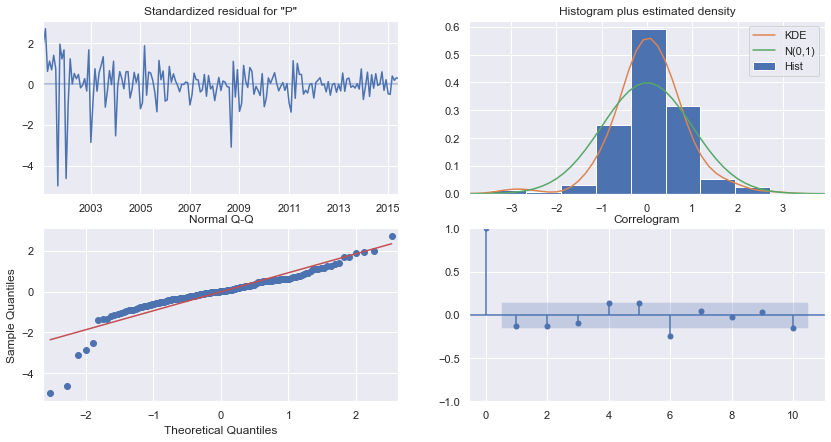

IAH-Dom full model is not parsimonious
IAH-Dom full model does not have normally distributed errors
IAH-Dom full model errors are homoskedastic
                                     SARIMAX Results                                      
Dep. Variable:                         PASSENGERS   No. Observations:                  249
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -3226.275
Date:                            Wed, 09 Mar 2022   AIC                           6468.550
Time:                                    16:25:18   BIC                           6496.658
Sample:                                01-01-2001   HQIC                          6479.865
                                     - 09-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

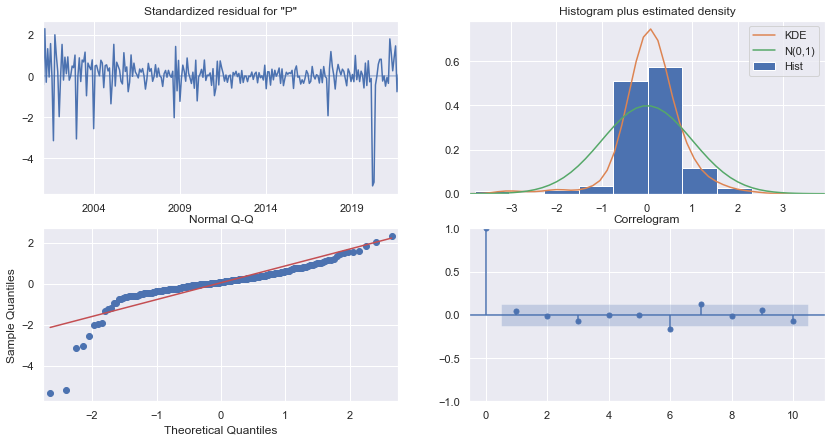

IAH-Int order: (4, 0, 2) x (0, 1, 2, 12)
------------------------------------------------------------------------------------------------------------------------
IAH-Int train model is not parsimonious
IAH-Int train model does not have normally distributed errors
IAH-Int train model errors are heteroskedastic
                                     SARIMAX Results                                      
Dep. Variable:                         PASSENGERS   No. Observations:                  174
Model:             SARIMAX(4, 0, 2)x(0, 1, 2, 12)   Log Likelihood               -1832.517
Date:                            Wed, 09 Mar 2022   AIC                           3683.034
Time:                                    16:25:22   BIC                           3710.822
Sample:                                01-01-2001   HQIC                          3694.316
                                     - 06-01-2015                                         
Covariance Type:                              opg   

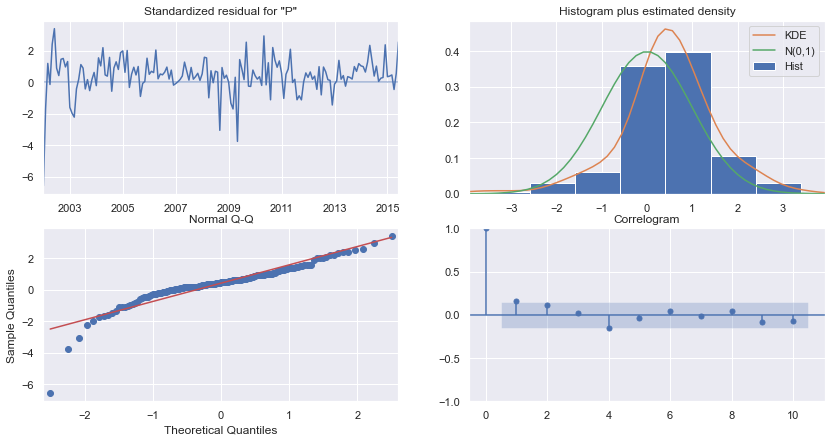

IAH-Int full model is not parsimonious
IAH-Int full model does not have normally distributed errors
IAH-Int full model errors are heteroskedastic
                                     SARIMAX Results                                      
Dep. Variable:                         PASSENGERS   No. Observations:                  249
Model:             SARIMAX(4, 0, 2)x(0, 1, 2, 12)   Log Likelihood               -2804.146
Date:                            Wed, 09 Mar 2022   AIC                           5626.291
Time:                                    16:25:25   BIC                           5657.504
Sample:                                01-01-2001   HQIC                          5638.872
                                     - 09-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

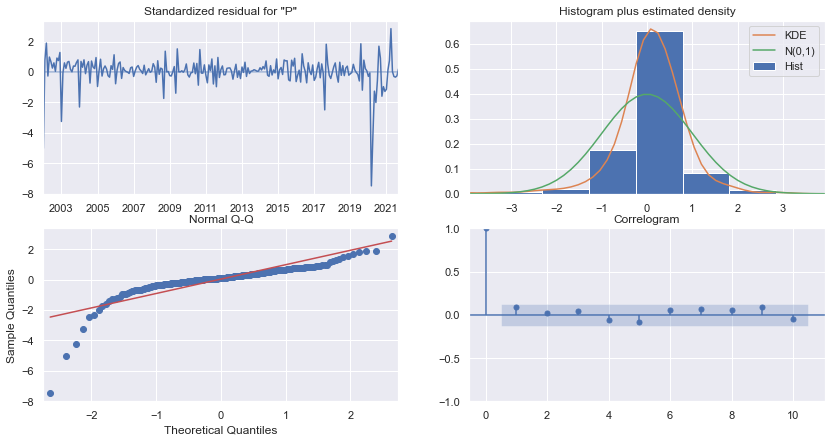

HOU-Dom order: (1, 1, 2) x (1, 0, 1, 12)
------------------------------------------------------------------------------------------------------------------------
HOU-Dom train model is not parsimonious
HOU-Dom train model does not have normally distributed errors
HOU-Dom train model errors are heteroskedastic
                                      SARIMAX Results                                       
Dep. Variable:                           PASSENGERS   No. Observations:                  174
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2034.152
Date:                              Wed, 09 Mar 2022   AIC                           4080.305
Time:                                      16:25:27   BIC                           4099.225
Sample:                                  01-01-2001   HQIC                          4087.980
                                       - 06-01-2015                                         
Covariance Type:                      

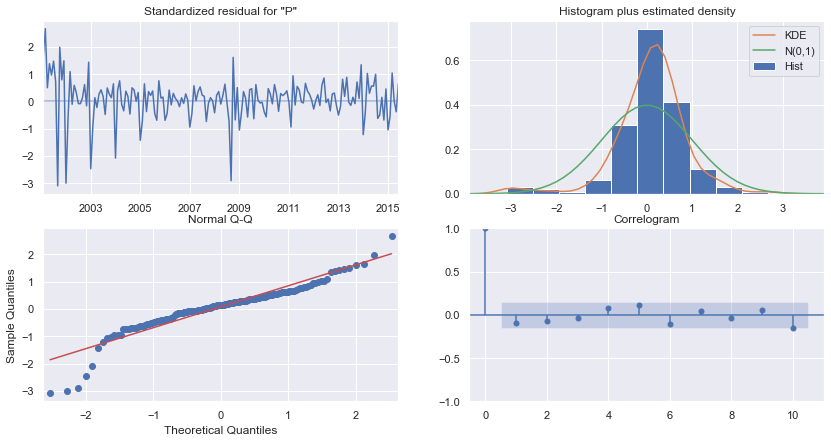

HOU-Dom full model is parsimonious
HOU-Dom full model does not have normally distributed errors
HOU-Dom full model errors are heteroskedastic
                                      SARIMAX Results                                       
Dep. Variable:                           PASSENGERS   No. Observations:                  249
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2990.037
Date:                              Wed, 09 Mar 2022   AIC                           5992.074
Time:                                      16:25:28   BIC                           6013.154
Sample:                                  01-01-2001   HQIC                          6000.560
                                       - 09-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

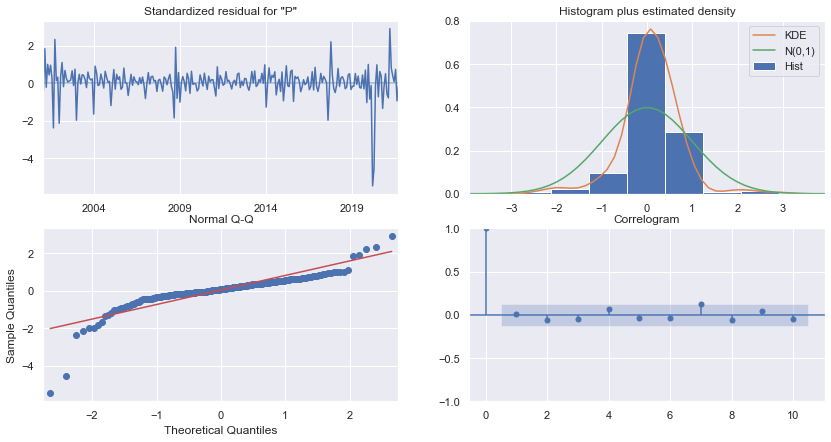

HOU-Int order: (0, 1, 0) x (0, 1, 1, 12)
------------------------------------------------------------------------------------------------------------------------
HOU-Int train model is not parsimonious
HOU-Int train model has normally distributed errors
HOU-Int train model errors are homoskedastic
                                      SARIMAX Results                                       
Dep. Variable:                           PASSENGERS   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -330.590
Date:                              Wed, 09 Mar 2022   AIC                            665.181
Time:                                      16:25:29   BIC                            668.291
Sample:                                  01-01-2016   HQIC                           666.254
                                       - 12-01-2019                                         
Covariance Type:                                op

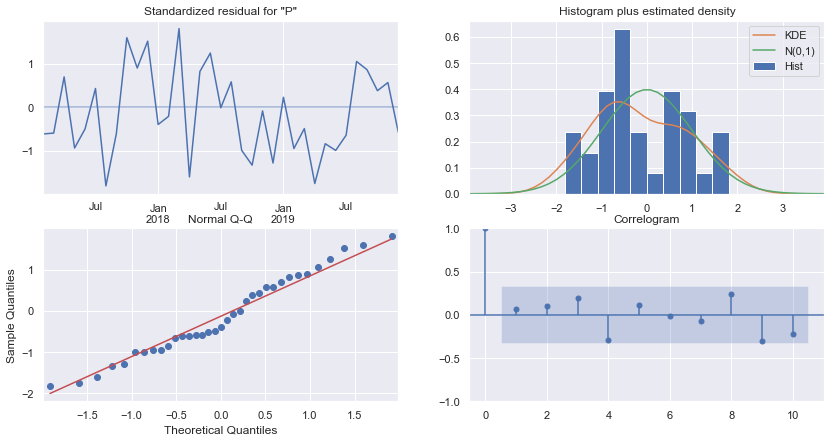

HOU-Int full model is parsimonious
HOU-Int full model does not have normally distributed errors
HOU-Int full model errors are homoskedastic
                                      SARIMAX Results                                       
Dep. Variable:                           PASSENGERS   No. Observations:                   69
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -568.983
Date:                              Wed, 09 Mar 2022   AIC                           1141.967
Time:                                      16:25:30   BIC                           1146.017
Sample:                                  01-01-2016   HQIC                          1143.537
                                       - 09-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

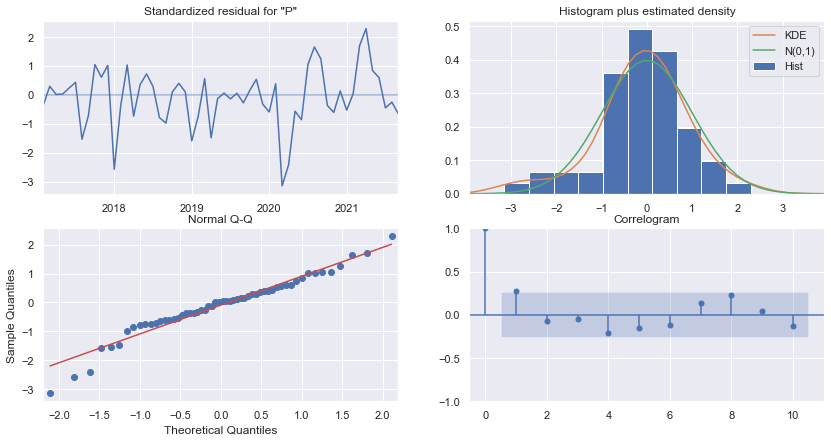

In [6]:
for series in series_map.keys():
    test_arima_model_validity(series)